In [1]:
import numpy as np
import cv2
import imutils
import skimage

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [2]:
def show_img(image):
    plt.figure(figsize=(16,16))
    plt.imshow(image)

In [3]:
path = r'overhead-science-2.png'
img = cv2.imread(path)

In [5]:
## isolate the table
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


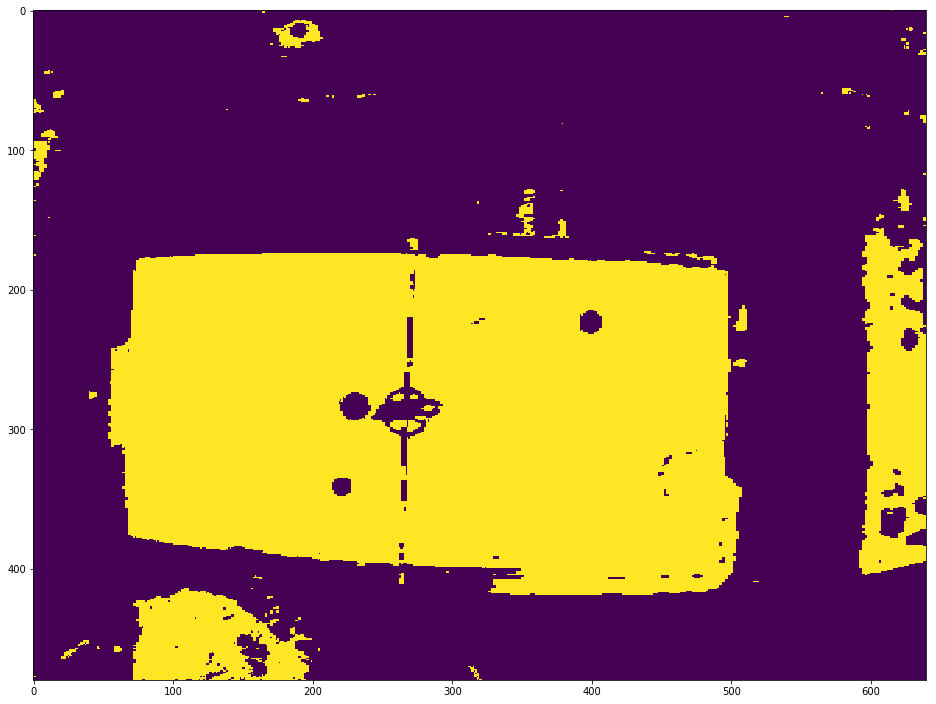

In [8]:
## isolate HUE

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
hsv[:,:,1:] = 0
t, hue = cv2.threshold(hsv, 50, 255, cv2.THRESH_BINARY)
hue = ~hue[:,:,0]
show_img(hue)

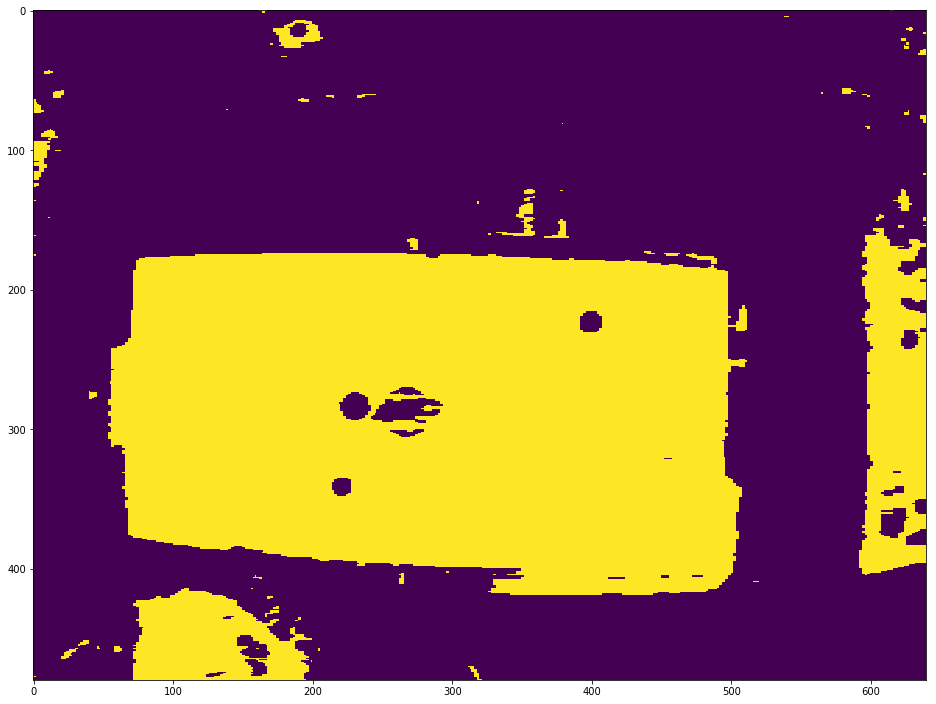

In [20]:
## denoise

kernel = np.ones((1, 1))
opened = cv2.morphologyEx(hue, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((1,5)))
show_img(closed)

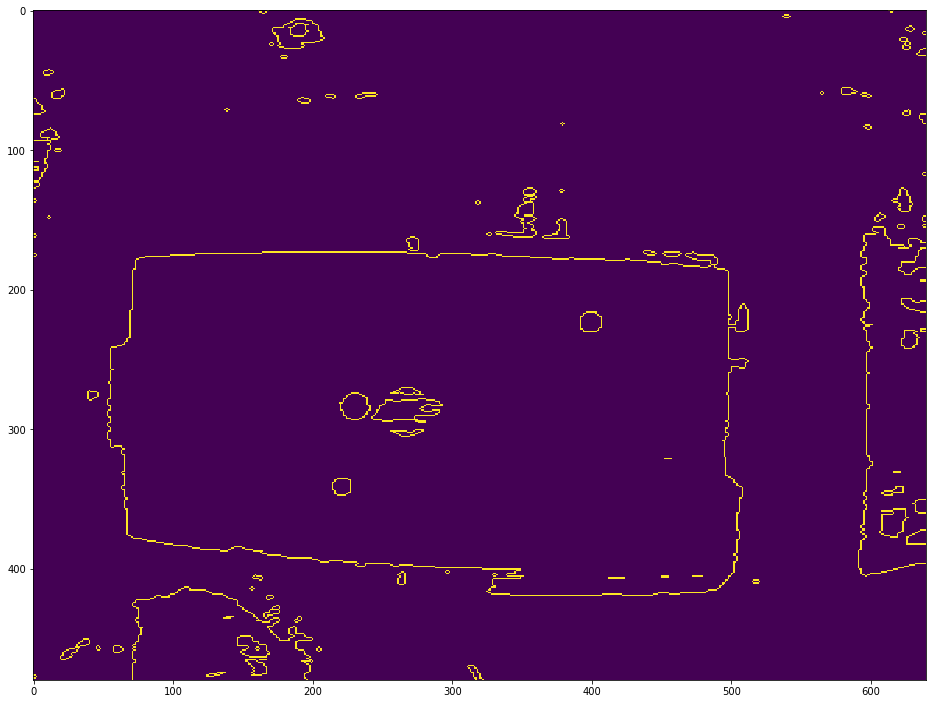

In [21]:
## edges are less work

laplacian = cv2.Laplacian(closed,cv2.CV_8UC1)
#edges = cv2.Canny(closed, 1, 1)
show_img(laplacian)

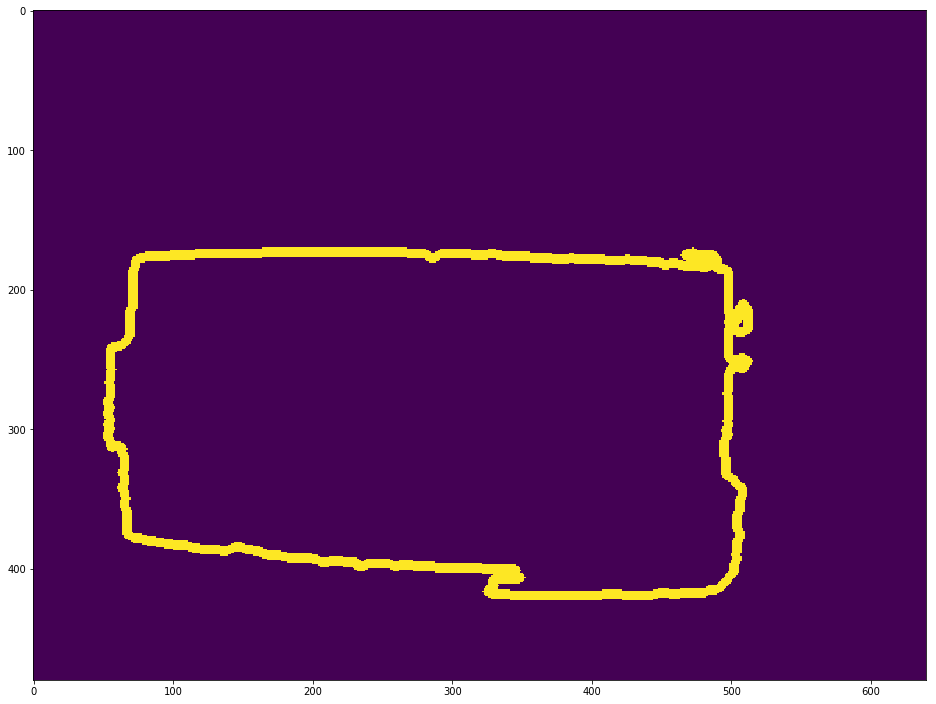

In [22]:
## find largest external blob

im2, outer_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
max_contour = max(outer_contours, key = cv2.contourArea)
test = cv2.drawContours(np.zeros_like(laplacian), [max_contour], -1, (255,255,255), 5)
show_img(test)

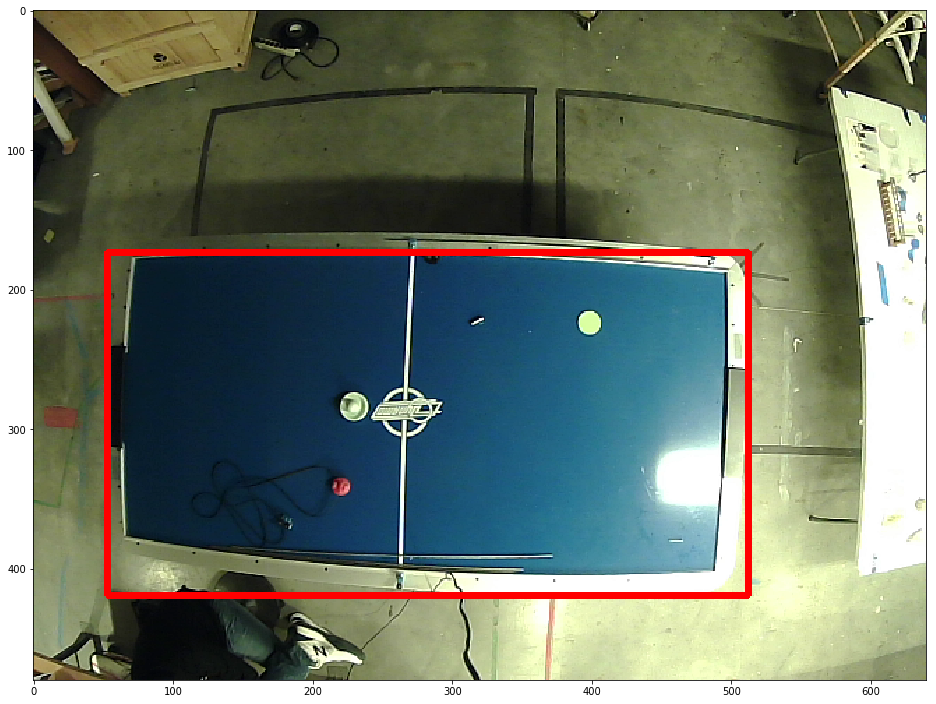

In [23]:
## translate playing area to a clean rect

rect = cv2.minAreaRect(max_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
disp = rgb.copy()
cv2.drawContours(disp,[box],0,(255,0,0),3)
show_img(disp)

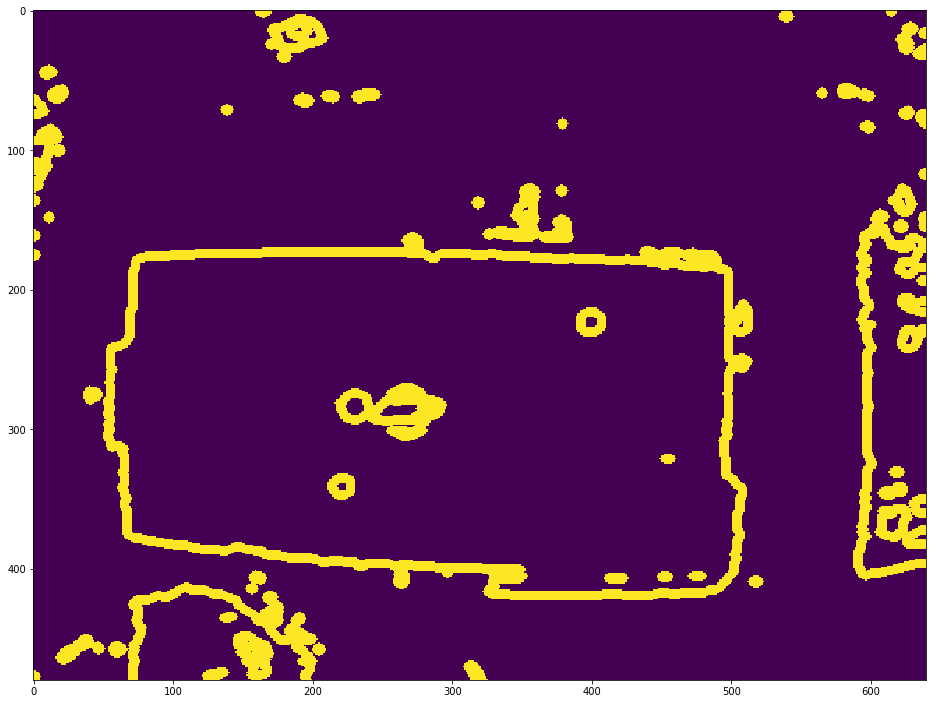

In [24]:
## draw all of the shapes

im2, all_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                                                   
test = cv2.drawContours(np.zeros_like(laplacian), all_contours, -1, (255,255,255), 5)
show_img(test)

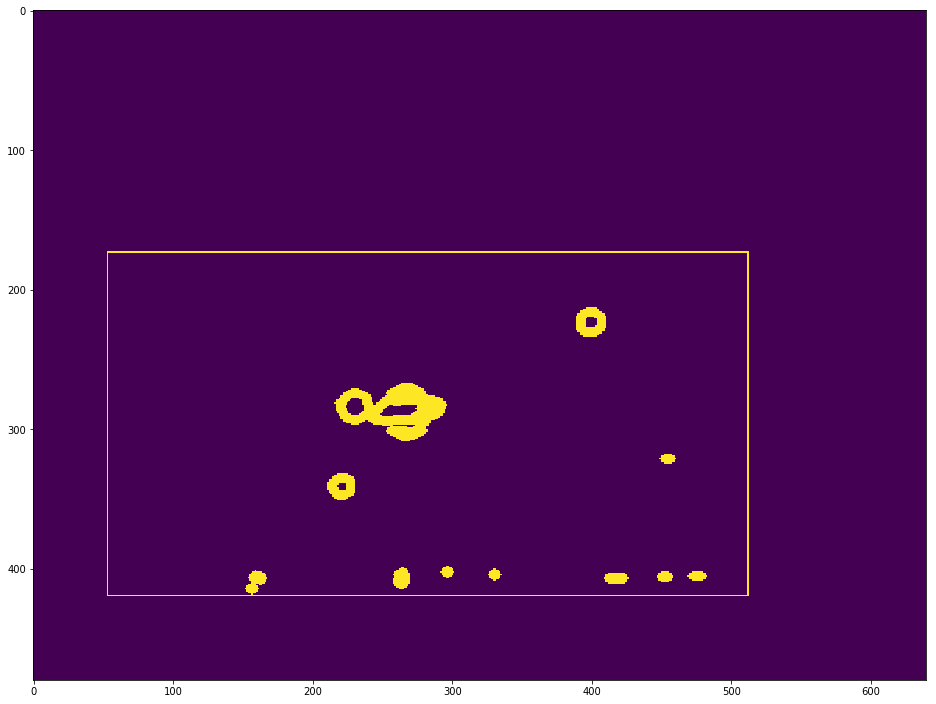

In [47]:
## isolate the shapes inside the table area

def point_in_box(point, box):
    return point[0] > min(box[:,0]) and point[0] < max(box[:,0]) and point[1] > min(box[:,1]) and point[1] < max(box[:,1])

contours_in_box = [c for c in all_contours if not (min(c[:,0,0]) <= min(box[:,0]) or max(c[:,0,0]) >= max(box[:,0]) or min(c[:,0,1]) <= min(box[:,1]) or max(c[:,0,1]) >= max(box[:,1]))]

disp = np.zeros_like(laplacian)
cv2.drawContours(disp, [box], 0, (255, 0, 0), 1)
cv2.drawContours(disp, contours_in_box, -1, (255,255,255), 5)
show_img(disp)

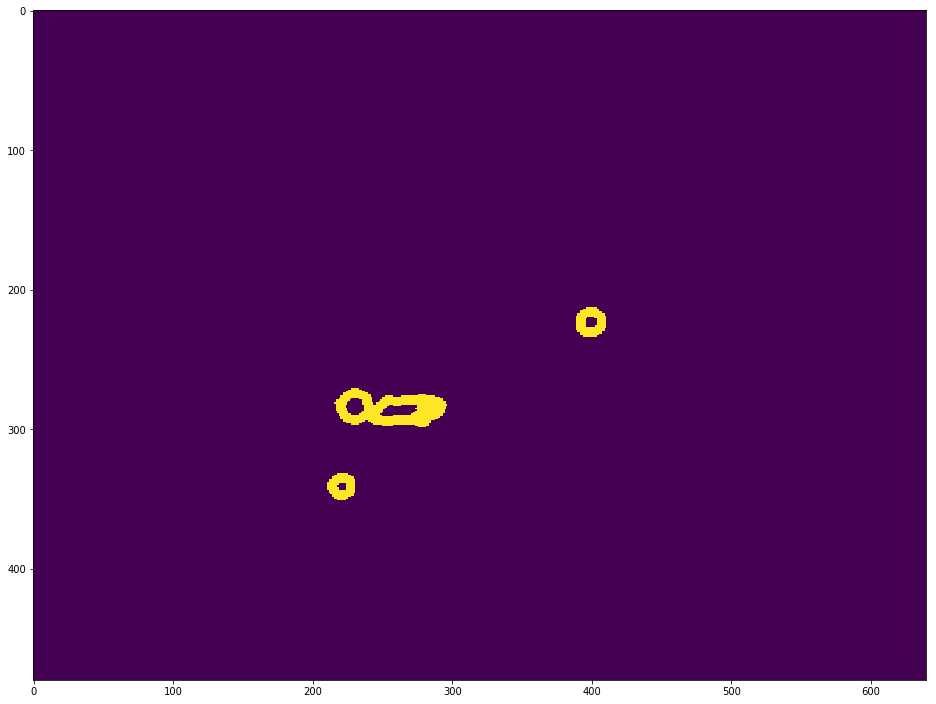

In [78]:
## filter out large shapes

def get_area(c):
    m = cv2.moments(c)
    return m['m00']

max_area = get_area(max_contour)
#print('Max Area = %.2f' %(max_area))

small_contours = [c for c in contours_in_box if (get_area(c) * 100 / max_area) < 50 and (get_area(c) * 100 / max_area) > 0.1]
test = cv2.drawContours(np.zeros_like(laplacian), small_contours, -1, (255,255,255), 5)
show_img(test)

In [102]:
## filter out non-circular shapes

def is_circle(c):
    polys = len(cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True))
    if polys < 8 || polys > 15:
        return False

    center, radius = cv2.minEnclosingCircle(c)
    area = get_area(c)
    circle_area = 3.14*radius*radius
    if abs(area-circle_area) > .25 * area:
        return False
    
    return True

circular_contours = [c for c in small_contours if is_circle(c)]

for c in circular_contours:
    center, radius = cv2.minEnclosingCircle(c)
    area = get_area(c)
    circle_area = 3.14*radius*radius
    print("p={} ci={} a={} ca={}".format(len(cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)), area, circle_area))
    test = cv2.drawContours(np.zeros_like(laplacian), [c], -1, (255,255,255), 2)
    show_img(test)

SyntaxError: invalid syntax (<ipython-input-102-91ce2e6beabb>, line 5)

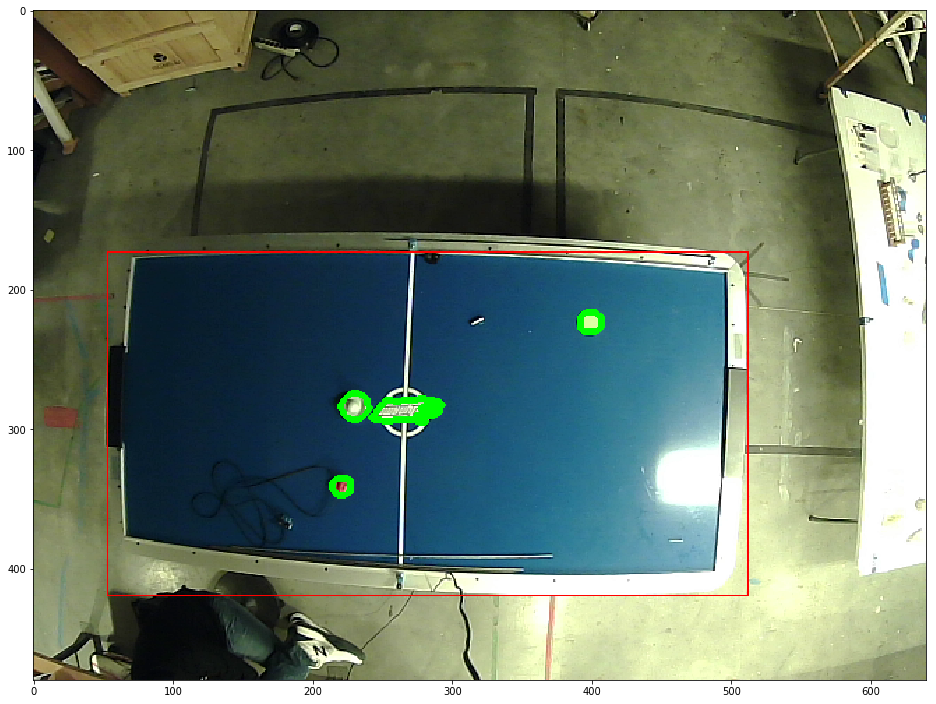

In [103]:
## put it all together

disp = rgb.copy()
cv2.drawContours(disp, [box], 0, (255, 0, 0), 1)
cv2.drawContours(disp, circular_contours, -1, (0,255,0), 3)
show_img(disp)

In [104]:
def annotate(img):
    
    ## isolate HUE
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,1:] = 0
    t, hue = cv2.threshold(hsv, 50, 255, cv2.THRESH_BINARY)
    hue = ~hue[:,:,0]

    ## denoise
    kernel = np.ones((1, 1))
    opened = cv2.morphologyEx(hue, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((1,5)))

    ## edges are less work
    laplacian = cv2.Laplacian(closed,cv2.CV_8UC1)

    ## find largest external blob
    im2, outer_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(outer_contours, key = cv2.contourArea)

    ## translate playing area to a clean rect
    rect = cv2.minAreaRect(max_contour)
    box = np.int0(cv2.boxPoints(rect))

    ## get all of the shapes
    im2, all_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    ## isolate the shapes inside the table area
    contours_in_box = [c for c in all_contours if not (min(c[:,0,0]) <= min(box[:,0]) or max(c[:,0,0]) >= max(box[:,0]) or min(c[:,0,1]) <= min(box[:,1]) or max(c[:,0,1]) >= max(box[:,1]))]

    ## filter out large shapes
    def get_area(c):
        m = cv2.moments(c)
        return m['m00']
    max_area = get_area(max_contour)
    small_contours = [c for c in contours_in_box if (get_area(c) * 100 / max_area) < 50 and (get_area(c) * 100 / max_area) > 0.1]

    ## filter out non-circular shapes
    def is_circle(c):
        polys = len(cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True))
        if polys < 8 or polys > 15:
            return False

        center, radius = cv2.minEnclosingCircle(c)
        area = get_area(c)
        circle_area = 3.14*radius*radius
        if abs(area-circle_area) > .75 * area:
            return False

        return True

    circular_contours = [c for c in small_contours if is_circle(c)]

    ## put it all together
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.drawContours(rgb, [box], 0, (255, 0, 0), 2)
    cv2.drawContours(rgb, circular_contours, -1, (0,255,0), 2)
    return rgb

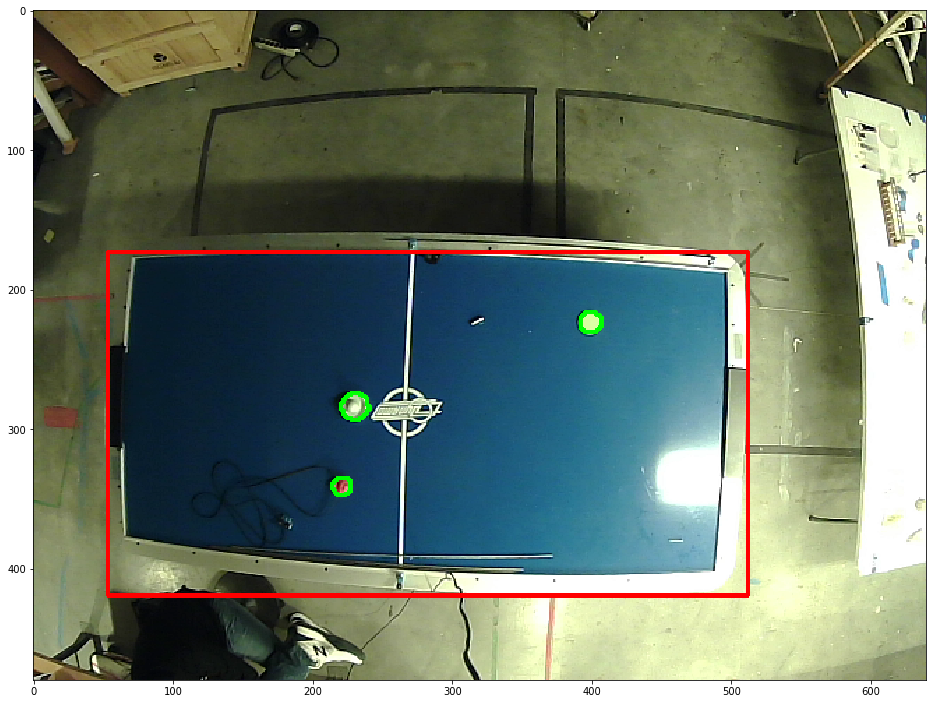

In [105]:
annotated = annotate(img)
show_img(annotated)